# Testing Notebook

This notebook is to input a model from training and test on new data

In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

# Plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Test Visualization

In [ ]:
# Read test EEG data from dat directory
test_file = pd.read_csv('t1_a6_dataset/GO/dk1_test_1673473168.csv', header=None)
test_file

In [ ]:
# Try test file

# Convert to numpy arrays
timestamps, tp9, af7, af8, tp10 = test_file.T.to_numpy()

# Get the frequency of the samples 
start = datetime.strptime(str(timestamps[0]), "%Y-%m-%d %H:%M:%S.%f")
end = datetime.strptime(str(timestamps[-1]), "%Y-%m-%d %H:%M:%S.%f")
duration = (end-start).total_seconds()
fs = timestamps.size/duration

Twtp9, Wtp9, *_ = ssq_cwt(tp9, fs=fs)
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(3, 1, 2)
plt.imshow(np.abs(Twtp9), aspect='auto', cmap='turbo')
fig.add_subplot(3, 1, 1)
plt.imshow(np.abs(Wtp9), aspect='auto', cmap='turbo')
plt.show()

## Importing Data

In [3]:
# Pull all training files data

# ENTER FILE EXTS HERE
data_path = './datasets/individual_dataset/'
test_name = 'dk*'

files = defaultdict(list)
file_types = ("GO", "REST", "STOP")
# file_types = ("GO", "REST", "STOP", "REMOVED")
    
for file_type in file_types:
    
    fileglob = os.path.join(data_path, file_type, '%s_1*.csv' % test_name)
    
    for i, file in enumerate(shuffle(glob.glob(fileglob))):
        files[file_type].append(pd.read_csv(file, header=None))

    print(len(files[file_type]))
    

52
94
46


## Signal Squeeze Wavelet Transform

In [3]:
def ts_to_ssq(timeseries):
    """
    Converts 4 channel time series data to ssq wavelet transform
    """
    timestamps, tp9, af7, af8, tp10 = timeseries
    
    # Get the frequency of the samples 
    start = datetime.strptime(str(timestamps[0]), "%Y-%m-%d %H:%M:%S.%f")
    end = datetime.strptime(str(timestamps[-1]), "%Y-%m-%d %H:%M:%S.%f")
    duration = (end-start).total_seconds()
    fs = timestamps.size/duration
    
    Twtp9, _, *_ = ssq_cwt(tp9, fs=fs)
    Twtp10, _, *_ = ssq_cwt(tp10, fs=fs)
    Twaf7, _, *_ = ssq_cwt(af7, fs=fs)
    Twaf8, _, *_ = ssq_cwt(af8, fs=fs)
    
    return np.array((Twtp9, Twaf7, Twaf8, Twtp10))

In [4]:
# Compile all files into test data
X = []
t = []

key_dict = {"STOP":(0.0, 1.0, 0.0),
            "GO":(1.0, 0.0, 0.0),
            "REST": (0.0, 0.0, 1.0)}

original_sample_size = 3000
buffer_sample_size = 500
training_sample_size = 25

def compile_files(files, file_type):
    X = []
    t = []
    
    num_files = sum([len(x) for x in files.values()])
    
    for key, data in files.items():
        for recording in data:
            # if file is smaller than 3000 samples, don't use it
            if len(recording[0]) < original_sample_size:
                continue

            # Split file into buffer size samples
            time_samples = np.split(recording.head(original_sample_size).T.to_numpy(),
                                         int(original_sample_size/buffer_sample_size), axis=1)

            for time_sample in time_samples:
                # Convert to numpy arrays
                ssq_data = ts_to_ssq(time_sample)

                # Take the magnitude of the wavelet transform only
                ssq_data = np.abs(ssq_data)

                # Must transpose data to (frame, height, channel) for training
                ssq_data = ssq_data.transpose(2,1,0)

                # Split sample into many blocks
                wavelet_samples = np.split(ssq_data, int(buffer_sample_size/training_sample_size))

                X.extend(wavelet_samples)
                t.extend([key_dict[key] for i in range(len(wavelet_samples))])
                
            num_files -= 1
            print("%d %s files left to convert " % (num_files, file_type), end="\r")
                
    return np.array(X), np.array(t)
        

In [6]:
X, t = compile_files(files, 'val')

In [7]:
print(len(X), X[0].shape)
print(len(t), t[0])

2400 (25, 229, 4)
2400 [1. 0. 0.]


In [8]:
SEED = 1
X, t = shuffle(np.array(X), np.array(t), random_state=SEED)

# Test Model

In [5]:
model = tf.keras.models.load_model('models/trial2/attempt4_500.h5')

2023-02-07 17:21:38.484925: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-02-07 17:21:38.558375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Tesla K20Xm computeCapability: 3.5
coreClock: 0.732GHz coreCount: 14 deviceMemorySize: 5.57GiB deviceMemoryBandwidth: 232.46GiB/s
2023-02-07 17:21:38.558833: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-07 17:21:38.561898: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-07 17:21:38.564126: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-07 17:21:38.564594: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-

In [9]:
results = model.evaluate(X, t, batch_size=1)

2023-02-07 17:24:06.618659: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-07 17:24:06.816873: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


2400/2400 [==============================] - 44s 18ms/step - loss: 1.7250 - accuracy: 0.5021


In [22]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(t, axis=1)

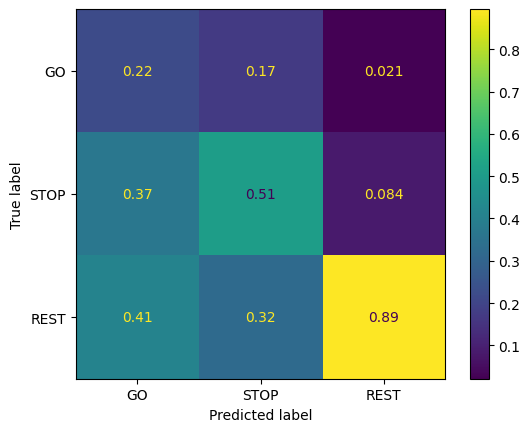

In [45]:
cm = confusion_matrix(y_test, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["GO", "STOP", "REST"])
disp.plot()

In [65]:
tf.keras.backend.clear_session()